In [87]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import sqlite3
import pandas as pd
import numpy as np
import sklearn.mixture
import sklearn.cluster

In [88]:
conn = sqlite3.connect("sabs_moonshot.db")
data = pd.read_sql_query("""
SELECT smiles, fingerprint, r_avg_IC50, f_avg_IC50
FROM assays
INNER JOIN compounds ON compounds.id = assays.compound_id
WHERE assays.r_avg_IC50 != "" OR assays.f_avg_IC50 != "";
""", conn)
pd.to_numeric(data["r_avg_IC50"], errors='coerce')
pd.to_numeric(data["f_avg_IC50"], errors='coerce')
data["r_avg_IC50"] = data["r_avg_IC50"].replace("", np.NaN)
data["f_avg_IC50"] = data["f_avg_IC50"].replace("", np.NaN)
conn.close()
data['avg_IC50'] = np.mean(data[["r_avg_IC50", "f_avg_IC50"]], axis=1).to_numpy()
db=data

db.head()

,smiles,fingerprint,r_avg_IC50,f_avg_IC50,avg_IC50
0,N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1,0000000000000000000000000000000000000000000000...,NaN,54.272964,54.272964
1,N#Cc1cccc(NC(=O)Nc2c[nH]c3ncccc23)c1,0000000000000000000000000000000000000000000000...,NaN,63.554925,63.554925
2,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,0000000000000000000000000000000000000000010000...,14.641091,26.680129,20.660610
3,O=C(Cc1cncc2ccccc12)Nc1ccccc1,0000000000000000000000000000000000000000010000...,45.077469,57.469670,51.273569
4,N#Cc1cc(Cl)cc(NC(=O)Nc2cccnc2)c1,0000000000000000000000000000000000000000000000...,NaN,99.010000,99.010000


In [89]:
#Construct a binary fingerprint for each compound in the database
N=len(db)
fps=[]
db['fingerprint']=np.nan
db
for i in range(N):
    cur_smiles=db['smiles'].iloc[i]
    cur_molecule=Chem.MolFromSmiles(cur_smiles)
    cur_fps=AllChem.GetMorganFingerprintAsBitVect(cur_molecule,2,nBits=2048,useFeatures=False,useChirality=False)
    fps.append(cur_fps)
    new_str=''
    db['fingerprint'].iloc[i]=''.join([str(i) for i in np.array(cur_fps)])
db.to_csv('fingerprints.csv')


C:\Users\marco\anaconda3\envs\data_science\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [90]:
#Construct a similarity matix using Tanimoto index
S=np.zeros((N,N))
for i in range(N):
    for j in range(N):
        S[i,j]=DataStructs.FingerprintSimilarity(fps[i],fps[j],metric=DataStructs.TanimotoSimilarity)
np.save('similarity_matrix',S)

Applying UMAP to fingerprints

In [91]:
from umap import UMAP
#Store fingerprints for each components in a matrix
FPS=np.zeros((N,2048))
for i in range(len(db)):
    FPS[i,:]=np.array(fps[i])


C:\Users\marco\anaconda3\envs\data_science\lib\site-packages\umap\umap_.py:1804: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


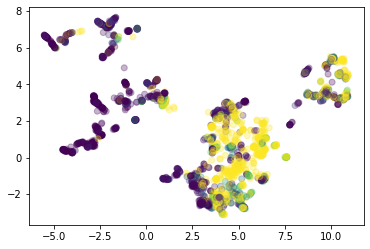

In [97]:
#Cluster using UMAP
reducer=UMAP(n_neighbors=80,n_components=2,metric='jaccard')
FPS_trans=reducer.fit_transform(FPS)
plt.scatter(FPS_trans[:,0],FPS_trans[:,1],c=c,alpha=0.3)

Clustering in the Low-dimentional space (Mixture Models)

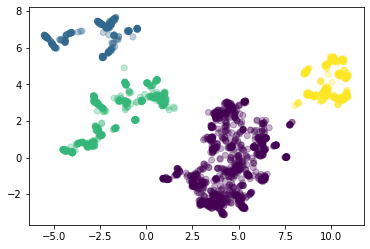

In [100]:
gm=sklearn.mixture.GaussianMixture(n_components=4)
gm=gm.fit(FPS_trans)
clusters_gm=gm.predict(FPS_trans)
plt.scatter(FPS_trans[:,0],FPS_trans[:,1],c=clusters_gm,alpha=0.3)

K-Means

(2435,)


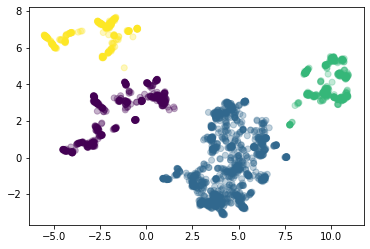

In [101]:
km=sklearn.cluster.KMeans(n_clusters=4)
km=km.fit(FPS_trans)
clusters=km.predict(FPS_trans)
print(clusters.shape)
plt.scatter(FPS_trans[:,0],FPS_trans[:,1],c=clusters,alpha=0.3)

In [96]:
fingerprint_data = pd.read_csv("fingerprints.csv")
import sqlite3
conn = sqlite3.connect("sabs_moonshot.db")
conn.executemany("""
    UPDATE compounds SET fingerprint = ? WHERE id = ?
""", fingerprint_data[["fingerprint", "id"]].values.tolist())
conn.commit()
conn.close()

KeyError: "['id'] not in index"